# Calculating Delta F over F for analyzed timelapse for GCaMP experiments.
## This is a Python version of the deltaFOverF.m Matlab code that I previously made
In a paper from 2008 in Nature Neuroscience, DeltaF over F is defined as the following (Supplementary Methods from: Greenberg, D.S. et al. Nat Neurosci 11, 749-751 (2008).): Denote neuron fluorescence for frame i by F(i) (note that each neuron is processed separately). Define baseline fluorescence F0(i) as the mean of the lowest 50% of fluorescence values measured within some number of seconds before or after frame i, and **\[DeltaF/F0](i)** = (F(i) - F0)/F0. So, for us, the number of seconds will be a variable number of frames before and after, which we will call 'windowVal'.

## Import libraries

In [452]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For finding multiple files with the same extension in a given path
import glob

# For interactive plotting
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 
import chart_studio.plotly as py

## Global variables
Change these variables if you would like a different sliding window, or a different value for defining what is actually an accepted peak (indicator of action potential) than the default for the deltaF/F0 calculation.

In [5]:
windowVal = 60; # Number of seconds on either side of a given frame
peakThresh = 0.45; # Above this value of deltaF/F0, we consider a peak to be a firing event

axFontS = 16; # Fontsize for Graph Axes Labels
indxFontS = 12; # Fontsize for index labels on graphs (e.g., actual time point values)

## User-directed input
Please change the following values for your particular dataset of interest.

**Change the path variable to the location of your data.**

In [104]:
path = '/Users/dtsloaner/Documents/GitHub/postdoc-scripts/gcamp' # change the path, if necessary

**What is the time interval for a given frame in the time lapse (i.e., seconds per frame)?**

In [105]:
timeInt = 1.9 # seconds per frame

**Add in the frame number for each perturbation in a list format [perturbation1,perturbation2,...,perturbationN].**

For example, if there were three perturbations at frames 100, 200, and 300, input the following into the "interv" variable: interv = \[100, 200, 300]

In [106]:
interv = [610,1085]

## Read Data
For this case, regions of interest were drawn around cells, neuropil, or a combination thereof in different regions of the zebrafish brain. The "Measure" tool was used in these regions to estimate the average intensity in that region for each time point in a time lapse movie. These values are stored in .csv files that are generated by Fiji. These .csv files can be immediately integrated into a growing dataframe, depending on how many columns are eventually desired.

The glob function allows one to make a list of all files with a particular extension within a given file path.

In [101]:
all_files_to_load = glob.glob(path + "/*.csv")

# Get each of the filenames, which will be used as column names for the dataframe
col_header = [[[all_files_to_load[i].split('.')[0] 
  for i in range(0,len(all_files_to_load))][li].split('/') 
 for li in range(0,len(all_files_to_load))][li2][-1] 
for li2 in range(0,len(all_files_to_load))]

Create a dataframe of intensity values. Each row represents a single time point in a time lapse movie. Each column represents a different *(i)* cell, *(ii)* region, or *(iii)* same region but different fish. Note that in the case of choosing the same region but different fish, ensure that the frame rate is the **same** for each fish, or else the graph will not be useful. Presumably, there are the same number of rows for each, but if there are not, the unfilled rows will just retain NaN values instead of actual numerical values.

In [102]:
df_intensities = pd.concat(
    (pd.read_csv(fnames,index_col=0,header=0).rename(columns={'Y':col_header[all_files_to_load.index(fnames)]}) 
     for fnames in all_files_to_load),
    axis=1)

# In case you want to sort the column indices in numerical order, uncomment the next line
#df_intensities = df_intensities.sort_index(axis=1)

In [138]:
df_intensities.tail(31)

,fish4_NicotineAlone2,fish4_NicotineAlone3,fish4_NicotineAlone
X,,,
2206,914.215,914.215,914.215
2207,842.956,NaN,842.956
2208,841.534,NaN,841.534
2209,943.271,NaN,943.271
2210,957.528,NaN,957.528
2211,861.722,NaN,861.722
2212,843.699,NaN,843.699
2213,879.468,NaN,879.468
2214,1000.761,NaN,1000.761


## Calculating deltaF/F
Using the windowVal parameter to determine the range for the sliding window and generating a new dataframe containing the deltaF/F values.

Using the "ceil" function to make sure that the sliding window on either side of a given frame is an integer value of frames. (Feel free to replace this with "floor" or "round", if that is preferred.)

In [127]:
window_frames = int(np.ceil(windowVal/timeInt)) # int function keeps this value as an integer


#### 2020-05-21 note: REMOVE LATER when replacing with a better possibility. If window_frames is too large, then just 
#### average the lowest values of the entire timelapse!
# Though this will likely never happen, in case window_frames is more than the total number of 
# frames in the movie, then set window_frames to be some very small default number. In this case,
# just do +/- one frame on either side of a given frame, which is a sad and small window.
if window_frames > len(df_intensities):
    window_frames = 1

### Defining functions that calculate deltaF/F0 taking into account sliding window
In this case, we need to take care of the fact that there are going to be four different conditions. Let's consider a particular frame, *fnum*, within a time lapse of length *N* for these situations.

1. When *fnum* is < window_frames:

    - F0 is calculated from frame 0 to *fnum*+window_frames
    

2. When *fnum* is >= window_frames **and** *fnum* is <= *N*-window_frames:

    - F0 is calculated from frame *fnum*-window_frames to *fnum*+window_frames
    

3. When *fnum* is > *N*-window_frames:

    - F0 is calculated from frame *fnum*-window_frames to *N*
    

4. If there are NaN values in the array (i.e., if one column has fewer rows than others in the dataframe):

    - Let *num_nan* be the number of rows that have NaN values.

    *N_new* = *N*-*num_nan*

Note that in the case of (4), all of the previous 3 could be affected, so check for that immediately.

In [388]:
# Important functions that are called to calculate the F0 values
def F0Calc_percentile(intensityFrame,pcnt=20):
    """
    This function calculates F0 as defined in Greenberg, D.S. et al. Nat Neurosci 11, 749-751 (2008).
    
    Parameters
    ----------
    intensityFrame: Dataframe with rows containing intensity information at a given timepoint. Columns
        represent each region that was isolated from an image using e.g., region of interest measurements.
        Note that this is usually a sliding window subset of a total time lapse.
    pcnt: integer value between 1 and 99 (inclusive) that represents the percentile of data that will
        be used for the calculation.
        Default is 20th percentile.
        
    Returns
    ---------
    Dataframe
        Dataframe with F0 values calculated from input intensity values.
    """
    if type(intensityFrame)==pd.core.series.Series:
        return np.percentile(intensityFrame,pcnt)
    else:
        return [np.percentile(intensityFrame[column],pcnt) for column in intensityFrame]

def F0Calc_average(intensityFrame,pcnt=50):
    """
    This function calculates F0 as defined in Greenberg, D.S. et al. Nat Neurosci 11, 749-751 (2008).
    
    Parameters
    ----------
    intensityFrame: Dataframe with rows containing intensity information at a given timepoint. Columns
        represent each region that was isolated from an image using e.g., region of interest measurements.
        Note that this is usually a sliding window subset of a total time lapse.
    pcnt: integer value between 1 and 99 (inclusive) that represents the percentile of data that will
        be used for the calculation.
        Default is average of lowest 50% of values within the sliding window.
        
    Returns
    ---------
    Dataframe
        Dataframe with F0 values calculated from input intensity values.
    """
    if type(intensityFrame)==pd.core.series.Series:
        return np.average(np.sort(intensityFrame)[0:int(np.ceil(len(intensityFrame)*pcnt/100))])
    else:
        return [np.average(np.sort(intensityFrame[column])
                           [0:int(np.ceil(len(intensityFrame)*pcnt/100))]) for column in intensityFrame]

In [426]:
def deltaFOverFCalc(intensityFrame, slidingWindow = 10, method_F0 = 'average.50'):
    """
    This function calculates deltaF/F0 as defined in Greenberg, D.S. et al. Nat Neurosci 11, 749-751 (2008).
    
    Parameters
    ----------
    intensityFrame: Dataframe with rows containing intensity information at a given timepoint. Columns
        represent each region that was isolated from an image using e.g., region of interest measurements.
    slidingWindow: Number of frames to check ahead of and behind a given frame during the analysis to
        calculate F0. This must be an integer value, but if it is not, it will become an integer with ceil().
        Default sliding window is 10 frames.
    method_F0: String to indicate which of two methods to use for calculating F0.
        'average.X': using the average of the lowest X% values within the sliding window as F0.
        'percentile.X': using the percentile function to figure out Xth percentile value for the sliding
            window and using that as F0.
        X must be between 1 and 99, inclusive.
        Default method is average of lowest 50% of values within the sliding window.
        
    Returns
    ---------
    Dataframe
        Dataframe with deltaF/F0 values calculated from input intensity values.
    """
    # Extracting the method used to calculate F0
    [method_used,pcntg]=method_F0.split('.')
    # Make sure percentage pcntg is an integer (again, needs to be between 1 and 99)
    pcntg = int(pcntg)
    
    # Total number of frames for each column in the dataframe
    num_fram = intensityFrame.count().to_list() # count neglects NaN values!
    
    # First, find the minimum length column in the dataframe.
    lowest_frame_num = min(num_fram)
    # If the sliding window is larger than the total number of timepoints,
    #     then, F0 needs to be calculated based on all frames in the dataframe.
    if slidingWindow > lowest_frame_num:
        if method_used == 'percentile':
            F0_val = F0Calc_percentile(intensityFrame,pcntg)
        elif method_used == 'average':
            F0_val = F0Calc_average(intensityFrame,pcntg)
        else:
            # Default will be average of lowest 50% of values of all timepoints in each column
            F0_val = F0Calc_average(intensityFrame,50)
            
            
    # Otherwise, we can use the sliding window approach for cases 1-3.
    else:
        # Initialize F0_val with NaN values
        F0_val = np.matlib.repmat(np.NaN,len(intensityFrame),len(intensityFrame.columns))
        F0_val= pd.DataFrame(data=F0_val,columns=intensityFrame.columns)
        for column in intensityFrame:
            for fnum in range(0,len(intensityFrame[column])):
                if method_used == 'percentile':
                    if fnum < slidingWindow:
                        F0_val[column][fnum] = F0Calc_percentile(intensityFrame[column][0:fnum+slidingWindow],pcntg)
                    elif fnum >= slidingWindow and fnum <= len(intensityFrame[column])-slidingWindow:
                        F0_val[column][fnum] = F0Calc_percentile(
                            intensityFrame[column][fnum-slidingWindow:fnum+slidingWindow],pcntg)
                    else:
                        F0_val[column][fnum] = F0Calc_percentile(
                            intensityFrame[column][fnum-slidingWindow:len(intensityFrame[column])],pcntg)
                # for when the method used is average (or default)
                else:
                    if fnum < slidingWindow:
                        F0_val[column][fnum] = F0Calc_average(intensityFrame[column][0:fnum+slidingWindow],pcntg)
                    elif fnum >= slidingWindow and fnum <= len(intensityFrame[column])-slidingWindow:
                        F0_val[column][fnum] = F0Calc_average(
                            intensityFrame[column][fnum-slidingWindow:fnum+slidingWindow],pcntg)
                    else:
                        F0_val[column][fnum] = F0Calc_average(
                            intensityFrame[column][fnum-slidingWindow:len(intensityFrame[column])],pcntg)
    
    # Return element by element subtraction followed by division of F0_val (F-F0)/F0
    return intensityFrame.subtract(F0_val).divide(F0_val)

## Calculate DeltaF/F0 using functions described above
Create a dataframe of DeltaF/F0 values.

In [457]:
df_dFOverF = deltaFOverFCalc(intensityFrame=df_intensities, slidingWindow = window_frames, method_F0 = 'average.50')

In [467]:
df_dFOverF.tail(31)

,fish4_NicotineAlone2,fish4_NicotineAlone3,fish4_NicotineAlone
X,,,
2206,0.065904,-0.01243,0.065904
2207,-0.015670,NaN,-0.015670
2208,-0.017331,NaN,-0.017331
2209,0.103111,NaN,0.103111
2210,0.119784,NaN,0.119784
2211,0.009335,NaN,0.009335
2212,-0.011776,NaN,-0.011776
2213,0.029593,NaN,0.029593
2214,0.171590,NaN,0.171590


In [468]:
# Debug: Test to see what happens when the length of the Dataframe being passed 
#   into deltaFOverFCalc is smaller than slidingWindow.
df_dFOverF2 = deltaFOverFCalc(intensityFrame=df_intensities.head(10), slidingWindow = window_frames, method_F0 = 'average.50')

## Plotting
Here, plot deltaF/F0 as well as the intensity plot, and indicate where drugs were added.

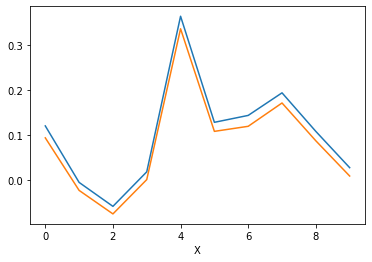

In [470]:
# Debugging, just seeing that the trend is the same for the calculation of dF/F0 when the dataframe is full
#    versus when it is just the first 10 values. (df_dFOverF versus df_dFOverF2, respectively)
df_dFOverF['fish4_NicotineAlone3'][0:10].plot()
df_dFOverF2['fish4_NicotineAlone3'].plot()

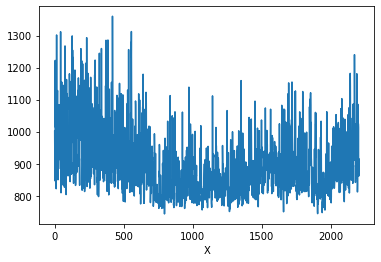

In [453]:
df_intensities['fish4_NicotineAlone3'].plot()